# **📌 الخطوة 1: تجهيز البيئة وتحميل المكتبات**

In [ ]:
# استيراد المكتبات الأساسية
import os
import numpy as np
import cv2
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import mediapipe as mp

print("تم تحميل المكتبات بنجاح!")


# **📌 الخطوة 2: تحميل وضبط بيانات الإشارة اليدوية**

In [ ]:
# Constants
NUM_CLASSES = 10
RANDOM_SEED = 45
BATCH_SIZE = 32
EPOCHS = 100
MODEL_PATH = "/content/sign_language_model.h5"


# تحديد مسار ملف ZIP الذي يحتوي على البيانات
zip_path = "/content/sign Language.v2i.yolov8.zip"  # تأكد من صحة اسم الملف
extract_to = "/content/dataset"  # المجلد الذي سيتم استخراج البيانات إليه

# التأكد من أن مجلد الاستخراج موجود
os.makedirs(extract_to, exist_ok=True)

# فك ضغط الملف
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("تم استخراج ملفات قاعدة البيانات بنجاح!")


# **📌 الخطوة 3: إنشاء النموذج العميق (Deep Learning Model)**

In [ ]:
class SignLanguageClassifier:
    def __init__(self):
        """
        دالة المُهيئ (Constructor) عند إنشاء كائن من هذا الكلاس
        - تحميل مكتبة MediaPipe لاكتشاف معالم اليد في الصور
        - استدعاء دالة _build_model() لإنشاء نموذج الذكاء الاصطناعي
        """
        self.mp_hands = mp.solutions.hands  # تحميل نموذج MediaPipe Hand Tracking
        self.hands = self.mp_hands.Hands(   # ضبط إعدادات الكشف عن اليد
            static_image_mode=True,  # وضع الكشف في الصور الثابتة
            max_num_hands=2,  # يمكن الكشف عن يد واحدة أو يدين
            min_detection_confidence=0.5  # نسبة الثقة المطلوبة لاكتشاف اليد
        )
        self.model = self._build_model()  # استدعاء دالة بناء النموذج

    def _build_model(self):
        """
        دالة بناء نموذج الشبكة العصبية العميقة باستخدام TensorFlow
        - يتكون من 3 طبقات مخفية
        - الطبقات تستخدم وظيفة التنشيط ReLU لتحسين الأداء
        - طبقة إخراج Softmax لتصنيف 10 إشارات مختلفة
        - يستخدم Adam optimizer لتحديث الأوزان أثناء التدريب
        """
        model = Sequential([
            Dense(256, activation='relu', input_shape=(126,)),  # الطبقة الأولى: 256 نيوترون مع ReLU
            Dropout(0.3),  # تقليل الإفراط في التعلّم (Overfitting) بنسبة 30%
            Dense(128, activation='relu'),  # الطبقة الثانية: 128 نيوترون مع ReLU
            Dropout(0.3),  # تقليل الإفراط في التعلّم مرة أخرى
            Dense(NUM_CLASSES, activation='softmax')  # طبقة الإخراج: عدد التصنيفات مع Softmax
        ])

        # تجميع النموذج (Compile) مع تحديد:
        # - 'adam' كمحسّن (Optimizer) لأنه فعال وسريع
        # - 'categorical_crossentropy' كخسارة لأننا نعمل مع تصنيف متعدد الفئات
        # - قياس دقة النموذج أثناء التدريب
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

print("تم تعريف كلاس النموذج بنجاح!")


# **📌 الخطوة 4: معالجة الصور لاستخراج معالم اليد**

In [ ]:
def process_image(self, image_path):
    """
    دالة لاستخراج معالم اليد من الصورة باستخدام MediaPipe

    المدخلات:
        image_path (str): مسار الصورة المطلوب معالجتها

    المخرجات:
        np.array أو None: مصفوفة تحتوي على إحداثيات معالم اليد (126 قيمة) أو None إذا لم يتم اكتشاف يد
    """

    # تحميل الصورة باستخدام OpenCV
    image = cv2.imread(image_path)
    if image is None:
        print(f"تحذير: لم يتم العثور على الصورة {image_path}!")
        return None  # إرجاع None في حال عدم العثور على الصورة

    # تحويل الصورة من BGR (المعيار الافتراضي لـ OpenCV) إلى RGB (المعيار المطلوب لـ MediaPipe)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # تمرير الصورة إلى MediaPipe لمعالجة اليد واستخراج المعالم
    results = self.hands.process(image_rgb)

    # إذا لم يتم العثور على يد في الصورة، نرجع None
    if not results.multi_hand_landmarks:
        return None

    # قائمة لتخزين معالم اليد
    landmarks = []

    # استخراج معالم اليد الأولى (إذا كانت موجودة)
    landmarks.extend(self._extract_landmarks(results.multi_hand_landmarks[0]))

    # التحقق مما إذا كان هناك يد ثانية في الصورة
    if len(results.multi_hand_landmarks) > 1:
        # استخراج معالم اليد الثانية (إن وجدت)
        landmarks.extend(self._extract_landmarks(results.multi_hand_landmarks[1]))
    else:
        # إذا لم تكن هناك يد ثانية، نقوم بتعبئة 63 قيمة بصفر للحفاظ على حجم المدخلات ثابتًا (126 قيمة)
        landmarks.extend([0.0] * 63)

    # تحويل القائمة إلى مصفوفة NumPy لسهولة الاستخدام مع الشبكة العصبية
    return np.array(landmarks)

print("تمت إضافة وظيفة معالجة الصور بنجاح!")


# **📌 الخطوة 5: تحميل البيانات وتقسيمها للتدريب والاختبار**

In [ ]:
def load_dataset(self, base_dir):
    """
    تحميل بيانات التدريب والاختبار والتأكد من سلامتها.

    المدخلات:
        base_dir (str): المجلد الرئيسي الذي يحتوي على البيانات المقسمة إلى train، test، valid.

    المخرجات:
        X (numpy array): بيانات معالم اليد المستخرجة من الصور.
        y (numpy array): التسميات (Labels) الخاصة بكل صورة، ممثلة كتصنيف متعدد الفئات.
    """

    # إنشاء قائمتين فارغتين لتخزين البيانات والتسميات
    X, y = [], []

    # الحلقات لتكرار عمليات التحميل على جميع تقسيمات البيانات (تدريب، اختبار، تحقق)
    for split in ['train', 'test', 'valid']:
        image_dir = os.path.join(base_dir, split, 'images')  # مسار مجلد الصور
        label_dir = os.path.join(base_dir, split, 'labels')  # مسار مجلد التسميات

        # التحقق مما إذا كانت المجلدات موجودة، إذا لم تكن كذلك، يتم تخطي القسم
        if not (os.path.exists(image_dir) and os.path.exists(label_dir)):
            print(f"⚠️ تخطي {split} directory: الصور أو التسميات مفقودة.")
            continue  # ننتقل إلى القسم التالي

        print(f"📂 جاري معالجة مجلد {split} ...")

        # تكرار على جميع ملفات التسميات الموجودة في المجلد
        for label_file in os.listdir(label_dir):
            image_name = label_file.replace('.txt', '.jpg')  # تحويل اسم الملف إلى اسم الصورة
            image_path = os.path.join(image_dir, image_name)  # تحديد المسار الكامل للصورة
            label_path = os.path.join(label_dir, label_file)  # تحديد المسار الكامل لملف التسمية

            # التحقق مما إذا كانت الصورة موجودة، إذا لم تكن كذلك، يتم تخطيها
            if not os.path.exists(image_path):
                print(f"⚠️ تحذير: لم يتم العثور على الصورة {image_name}، يتم تخطيها ...")
                continue

            # استخراج معالم اليد من الصورة باستخدام الدالة process_image()
            landmarks = self.process_image(image_path)
            if landmarks is None:
                print(f"⚠️ تحذير: لم يتم الكشف عن معالم اليد في {image_name}")
                continue  # تخطي هذه الصورة

            # قراءة ملف التسمية (Label) المرتبط بالصورة
            with open(label_path, 'r') as f:
                label = int(f.readline().strip().split()[0])  # قراءة أول رقم في الملف كتصنيف للصورة

            # إضافة المعالم والتسمية إلى القوائم
            X.append(landmarks)
            y.append(label)

    # التحقق مما إذا تم العثور على أي بيانات، إذا لم يكن كذلك، يتم إرجاع None
    if not X:
        print("❌ خطأ: لم يتم العثور على صور صالحة في قاعدة البيانات!")
        return None, None

    # تحويل القوائم إلى مصفوفات NumPy لاستخدامها في التدريب
    return np.array(X), to_categorical(y, NUM_CLASSES)

print("✅ تم تحميل قاعدة البيانات بنجاح!")


# **📌 الخطوة 6: تدريب النموذج**

In [ ]:
classifier = SignLanguageClassifier()
X, y = classifier.load_dataset("/content/dataset")

if X is not None and y is not None:
    classifier.train(X, y)


In [3]:
!pip install mediapipe


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 21.8 MB/s eta 0:00:00


ZIP file extracted successfully!
Processing train directory...
Processing test directory...
Processing valid directory...
Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 162ms/step - accuracy: 0.2450 - loss: 2.1472 - val_accuracy: 0.4444 - val_loss: 1.8081
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4557 - loss: 1.7650 - val_accuracy: 0.3889 - val_loss: 1.6551
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4535 - loss: 1.6793 - val_accuracy: 0.4524 - val_loss: 1.5325
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5358 - loss: 1.5945 - val_accuracy: 0.5317 - val_loss: 1.4379
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5386 - loss: 1.4520 - val_accuracy: 0.5635 - val_loss: 1.3367
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5975 - loss: 1.2595 - val_accuracy: 0.6111 - val_loss: 1.2734
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6283 - loss: 1.1927 - val_accuracy: 0.5476 - val_

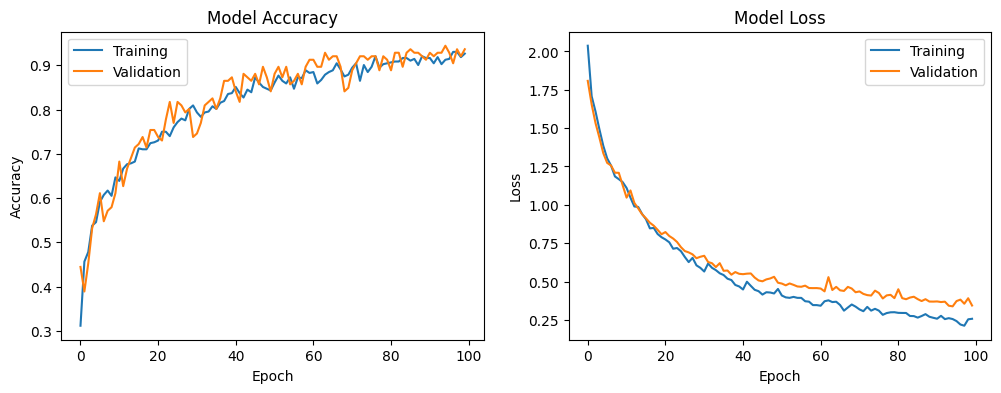

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9527 - loss: 0.2557 



Test Accuracy: 93.65%
Test Loss: 0.3438


In [20]:
import os
import numpy as np
import cv2
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import mediapipe as mp

# Constants
NUM_CLASSES = 10
RANDOM_SEED = 45
BATCH_SIZE = 32
EPOCHS = 100
MODEL_PATH = "/content/sign_language_model.h5"

# Extract dataset in Colab
zip_path = "/content/sign Language.v2i.yolov8.zip"  # Update the actual ZIP file path
extract_to = "/content/dataset"

os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("ZIP file extracted successfully!")


class SignLanguageClassifier:
    def __init__(self):
        self.mp_hands = mp.solutions.hands
        self.hands = self.mp_hands.Hands(
            static_image_mode=True,
            max_num_hands=2,
            min_detection_confidence=0.5
        )
        self.model = self._build_model()

    def _build_model(self):
        """Create neural network architecture"""
        model = Sequential([
            Dense(256, activation='relu', input_shape=(126,)),
            Dropout(0.3),
            Dense(128, activation='relu'),
            Dropout(0.3),
            Dense(NUM_CLASSES, activation='softmax')
        ])
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

    def process_image(self, image_path):
        """Extract hand landmarks from image"""
        image = cv2.imread(image_path)
        if image is None:
            print(f"Warning: Image {image_path} not found!")
            return None

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = self.hands.process(image_rgb)

        if not results.multi_hand_landmarks:
            return None

        landmarks = []
        landmarks.extend(self._extract_landmarks(results.multi_hand_landmarks[0]))

        if len(results.multi_hand_landmarks) > 1:
            landmarks.extend(self._extract_landmarks(results.multi_hand_landmarks[1]))
        else:
            landmarks.extend([0.0] * 63)  # Pad for second hand

        return np.array(landmarks)

    def _extract_landmarks(self, hand_landmarks):
        """Extract x,y,z coordinates from landmarks"""
        return [coord for landmark in hand_landmarks.landmark
                for coord in (landmark.x, landmark.y, landmark.z)]

    def load_dataset(self, base_dir):
        """Load dataset from extracted folder"""
        X, y = [], []

        for split in ['train', 'test', 'valid']:
            image_dir = os.path.join(base_dir, split, 'images')
            label_dir = os.path.join(base_dir, split, 'labels')

            if not (os.path.exists(image_dir) and os.path.exists(label_dir)):
                print(f"Skipping {split} directory: missing images or labels.")
                continue  # Skip if folders don't exist

            print(f"Processing {split} directory...")

            for label_file in os.listdir(label_dir):
                image_name = label_file.replace('.txt', '.jpg')
                image_path = os.path.join(image_dir, image_name)
                label_path = os.path.join(label_dir, label_file)

                if not os.path.exists(image_path):
                    print(f"Warning: Image {image_name} not found, skipping...")
                    continue

                landmarks = self.process_image(image_path)
                if landmarks is None:
                    print(f"Warning: No landmarks detected in {image_name}")
                    continue

                with open(label_path, 'r') as f:
                    label = int(f.readline().strip().split()[0])

                X.append(landmarks)
                y.append(label)

        if not X:
            print("Error: No valid images found in dataset!")
            return None, None

        return np.array(X), to_categorical(y, NUM_CLASSES)

    def train(self, X, y, validation_split=0.2):
        """Train the model"""
        if X is None or y is None:
            print("Error: Dataset is empty, cannot train!")
            return

        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            test_size=validation_split,
            random_state=RANDOM_SEED,
        )

        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=EPOCHS,
            batch_size=BATCH_SIZE
        )

        self.plot_training_history(history)
        self.evaluate(X_test, y_test)
        self.model.save(MODEL_PATH)

    def plot_training_history(self, history):
        """Plot accuracy and loss curves"""
        plt.figure(figsize=(12, 4))

        # Accuracy plot
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training')
        plt.plot(history.history['val_accuracy'], label='Validation')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        # Loss plot
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Training')
        plt.plot(history.history['val_loss'], label='Validation')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.show()

    def evaluate(self, X_test, y_test):
        """Evaluate model performance"""
        loss, accuracy = self.model.evaluate(X_test, y_test)
        print(f"\nTest Accuracy: {accuracy*100:.2f}%")
        print(f"Test Loss: {loss:.4f}")


# Main execution
if __name__ == "__main__":
    classifier = SignLanguageClassifier()
    X, y = classifier.load_dataset("/content/dataset")

    if X is not None and y is not None:
        classifier.train(X, y)


NameError: name 'keras' is not defined